In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("sclimbic_output/sclimbic_volumes_all.csv")

In [4]:
df.head()

,case,Left-Nucleus-Accumbens,Right-Nucleus-Accumbens,Left-HypoThal-noMB,Right-HypoThal-noMB,Left-Fornix,Right-Fornix,Left-MammillaryBody,Right-MammillaryBody,Left-Basal-Forebrain,Right-Basal-Forebrain,Left-SeptalNuc,Right-SeptalNuc,eTIV
0,sub-561230PV_ses-1_T1w,391.3532,425.0864,432.7347,447.6708,494.8329,581.6072,62.3889,66.3118,325.8429,360.5298,120.6973,122.6665,1.037198e+06
1,sub-561230PV_ses-2_T1w,251.3988,270.1646,372.7118,394.6465,374.7776,335.2044,54.6505,70.3596,251.2069,291.1911,108.3337,102.6719,1.279477e+06
2,sub-561230PV_ses-3_T1w,171.9109,194.6711,342.3278,356.0924,212.6339,255.5058,46.0859,61.7726,157.5003,228.8239,90.5745,86.4208,1.300733e+06
3,sub-570226LD_ses-1_T1w,300.4666,318.6597,439.6470,427.5719,405.9556,362.2469,58.7780,65.1289,344.9737,373.4046,105.4529,98.2306,1.366261e+06
4,sub-570226LD_ses-2_T1w,173.7347,187.0540,423.3690,424.0515,269.1702,265.5680,60.9708,65.0657,231.7649,287.4189,115.6659,98.9140,1.432902e+06


In [5]:
df[df['case'].str.contains('sub-561230PV')]

,case,Left-Nucleus-Accumbens,Right-Nucleus-Accumbens,Left-HypoThal-noMB,Right-HypoThal-noMB,Left-Fornix,Right-Fornix,Left-MammillaryBody,Right-MammillaryBody,Left-Basal-Forebrain,Right-Basal-Forebrain,Left-SeptalNuc,Right-SeptalNuc,eTIV
0,sub-561230PV_ses-1_T1w,391.3532,425.0864,432.7347,447.6708,494.8329,581.6072,62.3889,66.3118,325.8429,360.5298,120.6973,122.6665,1.037198e+06
1,sub-561230PV_ses-2_T1w,251.3988,270.1646,372.7118,394.6465,374.7776,335.2044,54.6505,70.3596,251.2069,291.1911,108.3337,102.6719,1.279477e+06
2,sub-561230PV_ses-3_T1w,171.9109,194.6711,342.3278,356.0924,212.6339,255.5058,46.0859,61.7726,157.5003,228.8239,90.5745,86.4208,1.300733e+06


In [6]:
subject_names = [ case.split('_')[0] for case in df['case']]
subject_names = np.unique(subject_names)
subject_names, subject_names.shape

(array(['sub-561230PV', 'sub-570226LD', 'sub-571216AT', 'sub-580620CG',
        'sub-580714PF', 'sub-581002PR', 'sub-600130DC', 'sub-600506GH',
        'sub-600816JLS', 'sub-601224NLL', 'sub-610415JD', 'sub-610612HV',
        'sub-611230FJ', 'sub-620204BD', 'sub-620227JB', 'sub-620818NC',
        'sub-620830MF', 'sub-630418CM', 'sub-630527GT', 'sub-630618AF',
        'sub-640107GB', 'sub-640425SV', 'sub-640427PV', 'sub-650328MCG',
        'sub-660125HM', 'sub-660412LM', 'sub-661117OP', 'sub-670213PC',
        'sub-670806JPP', 'sub-671019NL', 'sub-680518AH', 'sub-680917AG',
        'sub-680930WD', 'sub-690408PM', 'sub-690510ND', 'sub-690526CR',
        'sub-691229DB', 'sub-710509KM', 'sub-720501GL', 'sub-731001LC',
        'sub-761229PN', 'sub-810305BB', 'sub-840909AD', 'sub-851225EM'],
       dtype='<U13'),
 (44,))

In [7]:
subjects = {}
for subject_name in subject_names:
    
    rows = df[df['case'].str.contains(subject_name)]
    #print('Subject: {}, Number of sessions: {}'.format(subject_name,rows.shape[0]))
    n_ses = rows.shape[0]
    if n_ses in subjects:
        subjects[n_ses].append(subject_name)
    else:
        subjects[n_ses] = [subject_name]

In [8]:
regions_slopes = {region : dict() for region in list(df.columns[1:-1])}
regions_percent = {region : 0 for region in list(df.columns[1:-1])}

In [9]:
rows

,case,Left-Nucleus-Accumbens,Right-Nucleus-Accumbens,Left-HypoThal-noMB,Right-HypoThal-noMB,Left-Fornix,Right-Fornix,Left-MammillaryBody,Right-MammillaryBody,Left-Basal-Forebrain,Right-Basal-Forebrain,Left-SeptalNuc,Right-SeptalNuc,eTIV
113,sub-851225EM_ses-1_T1w,428.0245,398.5378,485.7227,500.7216,515.3477,520.8796,56.6751,58.5832,315.8894,331.2284,100.6950,97.7037,1.162948e+06
114,sub-851225EM_ses-2_T1w,460.4597,460.7467,522.5929,518.6761,511.8454,514.7566,55.1907,59.5580,310.8178,341.9633,98.9336,94.4100,1.704742e+06


In [11]:
X = np.array([7,366/2,3*365]).reshape(-1,1)

regions_c = {region : 0 for region in list(df.columns[1:-1])}
regions_cc = {region : 0 for region in list(df.columns[1:-1])}
    
for subject_name in subjects[3]:
    rows = df[df['case'].str.contains(subject_name)]
    for column, slopes_dict in regions_slopes.items():

        seq = rows[column]
        y = seq / rows['eTIV']
        is_decreasing = np.all(np.diff(np.flip(y)) >= 0)
        regions_cc[column] += 1
        if is_decreasing:
            #print(subject_name,column)
            regions_c[column] += 1
            reg = LinearRegression().fit(X, y)
            #print(np.array(y),reg.coef_,reg.score(X, y))
            slopes_dict[subject_name] = reg.coef_[0]
        regions_percent[column] = regions_c[column]/regions_cc[column] * 100

In [64]:
for r in list(df.columns[1:-1]):
    regions_percent[r] = regions_c[r]/regions_cc[r]* 100
print('average of {}%'.format(round(np.mean(np.array(list(regions_percent.values()))))))

average of 32%


In [17]:
db = pd.read_excel("Database.xlsx")
age_dict = dict(zip("sub-" + db["ID_MRI"],db["AGE"]))
moca_j7_dict = dict(zip("sub-" + db["ID_MRI"],db["MOCA_SCORE_J7"]))

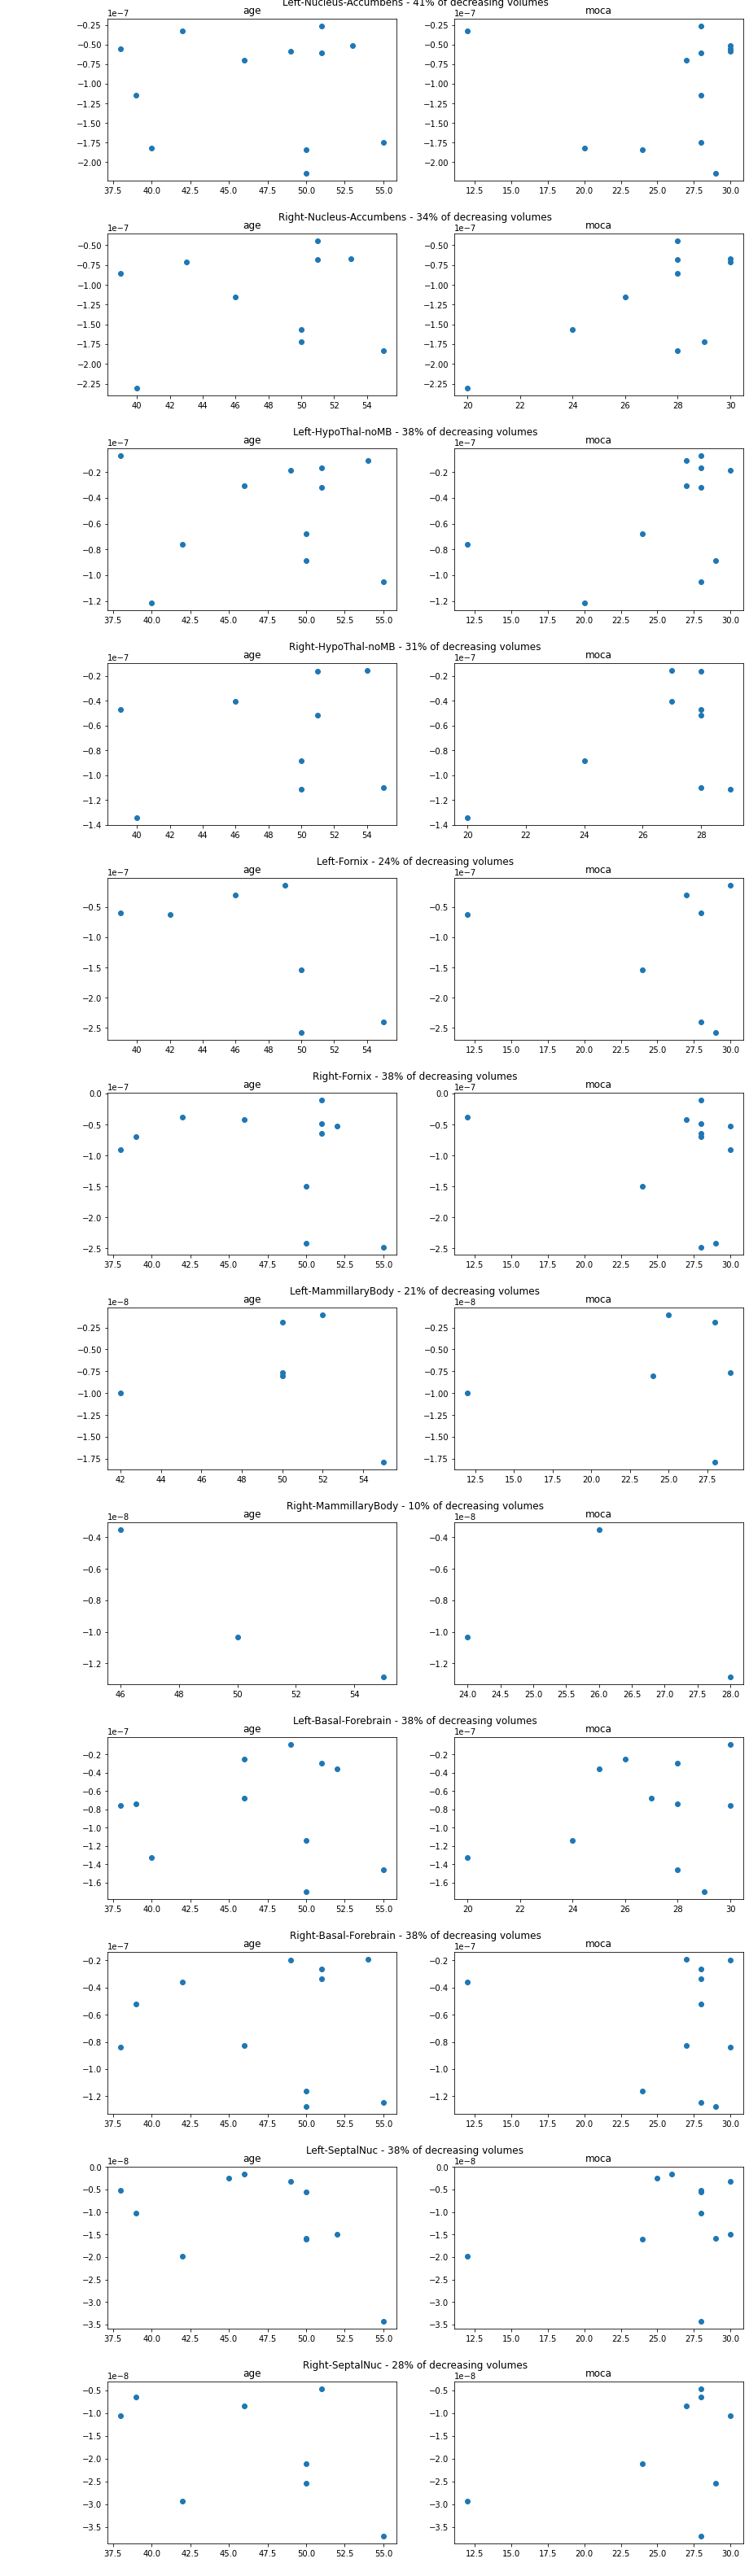

In [18]:
fig = plt.figure(figsize=(14,44))
i = 0
subfigs = fig.subfigures(nrows=len(regions_slopes), ncols=1)
for region in regions_slopes.keys():
    #plt.subplot(len(regions_slopes), 1, i+1)
    n = len(regions_slopes[region])
    ages = np.zeros(n)
    slopes = np.zeros(n)
    moca_j7 = np.zeros(n)
    for j, subject in enumerate(regions_slopes[region]):
        ages[j] = age_dict[subject]
        slopes[j] = regions_slopes[region][subject]
        moca_j7[j] = moca_j7_dict[subject]
    subfigs[i].suptitle("{} - {}% of decreasing volumes".format(region, round(regions_percent[region])))
    axs = subfigs[i].subplots(nrows = 1, ncols = 2)
    axs[0].scatter(ages, slopes)
    axs[0].set_title("age")
    axs[1].scatter(moca_j7, slopes)
    axs[1].set_title("moca")
    i+= 1

In [46]:
regions_first = {region : dict() for region in list(df.columns[1:-1])}
for subject_name in subject_names:
    row = df[df['case'].str.contains(subject_name)].iloc[0]
    for region in row.index[1:-1]:
        regions_first[region][subject_name] = row[region]

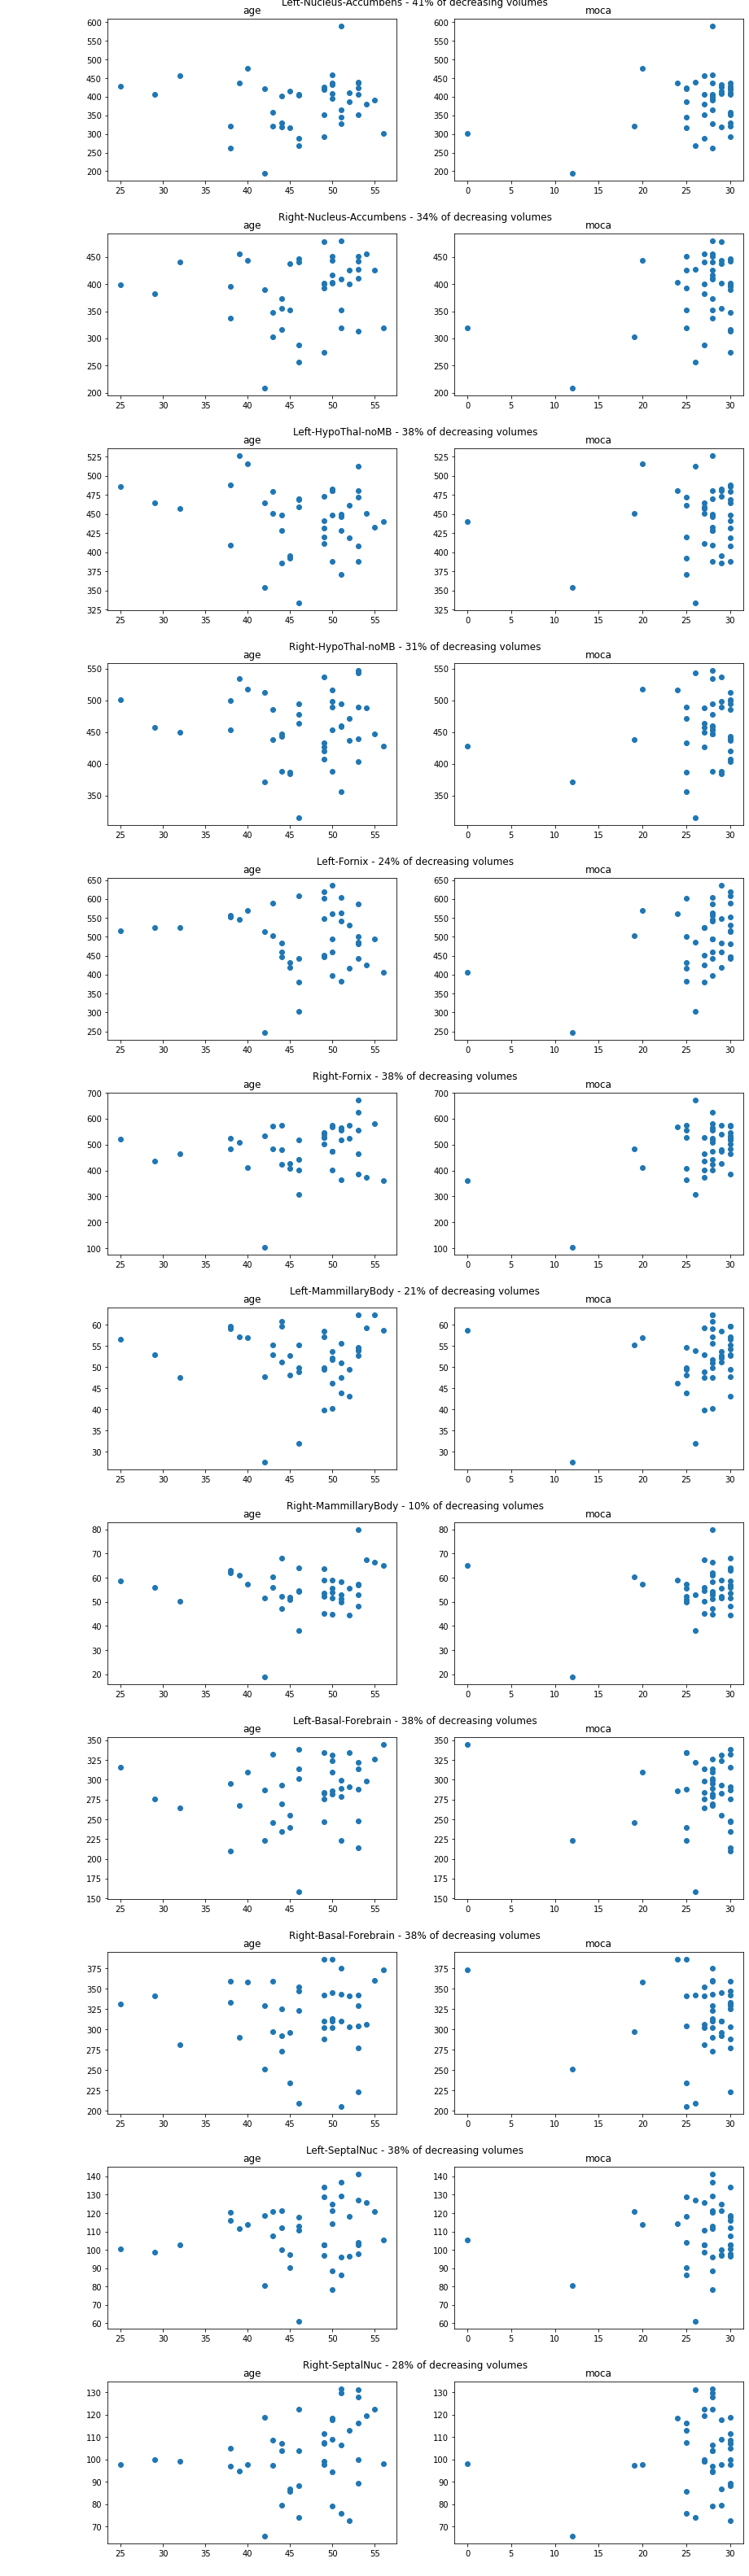

In [47]:
fig = plt.figure(figsize=(14,44))
i = 0
subfigs = fig.subfigures(nrows=len(regions_slopes), ncols=1)
for region in regions_slopes.keys():
    #plt.subplot(len(regions_slopes), 1, i+1)
    n = len(regions_first[region])
    ages = np.zeros(n)
    first = np.zeros(n)
    moca_j7 = np.zeros(n)
    for j, subject in enumerate(regions_first[region]):
        ages[j] = age_dict[subject]
        first[j] = regions_first[region][subject]
        moca_j7[j] = moca_j7_dict[subject]
    subfigs[i].suptitle("{} - {}% of decreasing volumes".format(region, round(regions_percent[region])))
    axs = subfigs[i].subplots(nrows = 1, ncols = 2)
    axs[0].scatter(ages, first)
    axs[0].set_title("age")
    axs[1].scatter(moca_j7, first)
    axs[1].set_title("moca")
    i+= 1

In [49]:
from scipy.stats import spearmanr

31.609195402298848